In [1]:
import os
from scipy.io import loadmat
import h5py

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load mat file data
mat = h5py.File(os.path.join("NYUv2", "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)

# Images are in 4D array (1449, 3, 640, 480), and depth maps are in 3D array (1449, 640, 480).
# We can simply transpose the axes to get them in a format suitable for training.

images = np.transpose(mat["images"], (0, 2, 3, 1))
depths = np.transpose(mat["depths"], (0, 2, 1))

# Shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
depths = depths[indices]

# Split data into training and validation
train_images = images[:1000]
train_depths = depths[:1000]
val_images = images[1000:]
val_depths = depths[1000:]

In [2]:
def crop_images(images, percentage):
    # The percentage should be between 0 and 1
    height, width = images.shape[1], images.shape[2]
    start_row = int(height * percentage / 2)
    end_row = height - start_row
    start_col = int(width * percentage / 2)
    end_col = width - start_col
    return images[:, start_row:end_row, start_col:end_col, :]

percentage = 0.20  

# Crop training images
train_images = crop_images(train_images, percentage)
val_images = crop_images(val_images, percentage)

In [3]:
print(train_images[0].shape)

(512, 384, 3)


In [4]:
# Extract depth value at the center
center_depths_train = train_depths[:, 320, 240]
center_depths_val = val_depths[:, 320, 240]

# normalize images for better network performance
train_images = train_images / 255.
val_images = val_images / 255.

# Reshape depths for suitable training 
center_depths_train = center_depths_train.reshape(-1, 1)
center_depths_val = center_depths_val.reshape(-1, 1)

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a new top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(1)(x)  # Output layer

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First, we will only train the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model (should be done after setting layers to non-trainable)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the new data for a few epochs
history = model.fit(train_images, center_depths_train, 
          epochs=20, validation_data=(val_images, center_depths_val))


Epoch 1/20
32/32 [==============================] - 12s 221ms/step - loss: 16.7929 - val_loss: 4.0615
Epoch 2/20
32/32 [==============================] - 5s 162ms/step - loss: 1.5595 - val_loss: 1.3196
Epoch 3/20
32/32 [==============================] - 5s 162ms/step - loss: 1.0427 - val_loss: 0.9592
Epoch 4/20
32/32 [==============================] - 5s 164ms/step - loss: 1.0471 - val_loss: 1.0174
Epoch 5/20
32/32 [==============================] - 5s 164ms/step - loss: 1.0037 - val_loss: 0.9247
Epoch 6/20
32/32 [==============================] - 5s 162ms/step - loss: 0.9688 - val_loss: 1.1707
Epoch 7/20
32/32 [==============================] - 5s 165ms/step - loss: 1.1283 - val_loss: 0.9081
Epoch 8/20
32/32 [==============================] - 5s 163ms/step - loss: 1.0198 - val_loss: 0.9056
Epoch 9/20
32/32 [==============================] - 5s 164ms/step - loss: 1.0246 - val_loss: 0.9125
Epoch 10/20
32/32 [==============================] - 5s 165ms/step - loss: 0.9456 - val_loss: 0.90

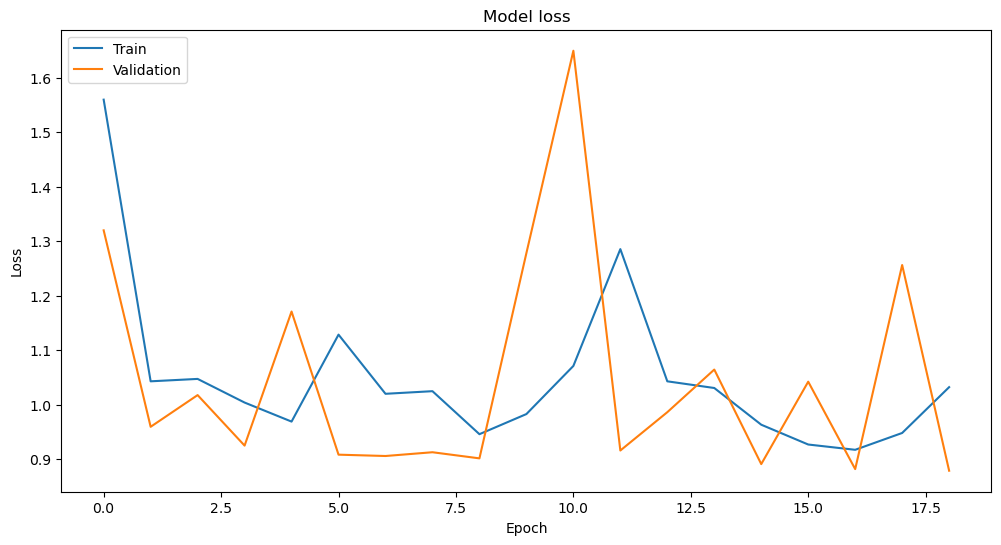

In [6]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [5]:
# Making predictions
predictions = model.predict(val_images[0:10])

# Compare the first 10 predicted distances with actual distances
for i in range(10):
    print(f"Predicted distance: {predictions[i][0]}, Actual distance: {center_depths_val[i][0]}")

1/1 [==============================] - 1s 1s/step
Predicted distance: 2.4477720260620117, Actual distance: 3.8452136516571045
Predicted distance: 3.0697288513183594, Actual distance: 3.39762020111084
Predicted distance: 3.6189496517181396, Actual distance: 3.603907823562622
Predicted distance: 2.8818352222442627, Actual distance: 2.3341495990753174
Predicted distance: 2.492704391479492, Actual distance: 1.982275128364563
Predicted distance: 2.465437173843384, Actual distance: 1.3973231315612793
Predicted distance: 2.529038667678833, Actual distance: 2.9601032733917236
Predicted distance: 2.4537599086761475, Actual distance: 3.023211717605591
Predicted distance: 2.3603389263153076, Actual distance: 2.413510799407959
Predicted distance: 2.716218948364258, Actual distance: 1.73985755443573


In [7]:
model.save('distance_prediction_ResNet.h5')

In [5]:
import tensorflow as tf

model = tf.keras.models.load_model('distance_prediction_ResNet.h5')

In [6]:
# Freeze all layers in the base model
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last layer
model.layers[-1].trainable = True

# Lower the learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(lr=0.00001)

# Recompile the model with the lower learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Retrain the model
history = model.fit(train_images, center_depths_train, batch_size = 16, 
          epochs=20, validation_data=(val_images, center_depths_val))


C:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
63/63 [==============================] - 13s 118ms/step - loss: 0.9081 - val_loss: 0.7794
Epoch 2/20
63/63 [==============================] - 6s 90ms/step - loss: 0.9060 - val_loss: 0.7803
Epoch 3/20
63/63 [==============================] - 6s 90ms/step - loss: 0.9067 - val_loss: 0.7813
Epoch 4/20
63/63 [==============================] - 6s 91ms/step - loss: 0.9060 - val_loss: 0.7802
Epoch 5/20
63/63 [==============================] - 6s 90ms/step - loss: 0.9061 - val_loss: 0.7805
Epoch 6/20
63/63 [==============================] - 6s 90ms/step - loss: 0.9060 - val_loss: 0.7803
Epoch 7/20
63/63 [==============================] - 6s 90ms/step - loss: 0.9063 - val_loss: 0.7809
Epoch 8/20
63/63 [==============================] - 6s 91ms/step - loss: 0.9060 - val_loss: 0.7803
Epoch 9/20
63/63 [==============================] - 6s 91ms/step - loss: 0.9069 - val_loss: 0.7811
Epoch 10/20
63/63 [==============================] - 6s 91ms/step - loss: 0.9064 - val_loss: 0.7804
Epoch 1

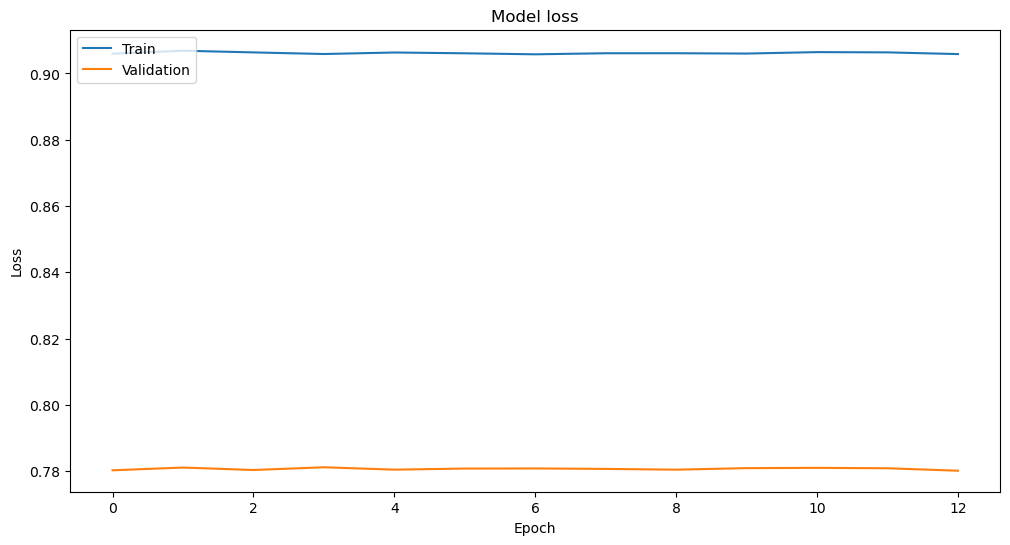

In [7]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][7:])
plt.plot(history.history['val_loss'][7:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
# Making predictions
predictions = model.predict(val_images[0:10])

# Compare the first 10 predicted distances with actual distances
for i in range(10):
    print(f"Predicted distance: {predictions[i][0]}, Actual distance: {center_depths_val[i][0]}")

1/1 [==============================] - 1s 949ms/step
Predicted distance: 2.549645185470581, Actual distance: 4.697354316711426
Predicted distance: 2.1146247386932373, Actual distance: 1.835012674331665
Predicted distance: 2.181345224380493, Actual distance: 2.3774728775024414
Predicted distance: 4.619805335998535, Actual distance: 4.898041248321533
Predicted distance: 2.109525442123413, Actual distance: 2.964648485183716
Predicted distance: 1.9605015516281128, Actual distance: 1.1043775081634521
Predicted distance: 2.4996135234832764, Actual distance: 1.853490948677063
Predicted distance: 2.498863697052002, Actual distance: 1.8631927967071533
Predicted distance: 5.155968189239502, Actual distance: 3.9790031909942627
Predicted distance: 3.1289896965026855, Actual distance: 0.8478106260299683
